In [3]:
import bclr
import ruptures as rpt
import numpy as np
from ruptures.metrics import randindex
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import multivariate_normal, binom
import matplotlib.pyplot as plt
import pandas as pd
import changeforest
from sklearn.linear_model import LogisticRegression, LinearRegression
from ecp import e_divisive

from scipy.special import comb
from scipy.stats import median_abs_deviation as mad
from sklearn.metrics import adjusted_rand_score

pf = PolynomialFeatures(include_bias=False)
ss = StandardScaler()

In [4]:
def kcp_slhr(signal, Dmax = 100, div_med = True, gamma=0.02, alpha=2):
    "Implements slope heuristic"
    mads = mad(np.abs(np.diff(signal, axis=0)), axis=0)
    if div_med:
        signal = signal/mads
    
    kcp_obj = rpt.KernelCPD(kernel='rbf', params={'gamma': gamma})
    cost_obj = rpt.costs.CostRbf(gamma=gamma)

    kcp_obj.fit(signal)
    cost_obj.fit(signal)
    
    Dlow = int(0.6*Dmax)
    y = []
    for k in range(1, Dmax+1):
        bkps_k = kcp_obj.predict(n_bkps=k)
        y.append(cost_obj.sum_of_costs(bkps_k))
    n = len(signal)
    x1 = np.log(comb(np.repeat(n-1, Dmax), np.arange(1, Dmax+1)-1))/n
    x2 = np.arange(1, Dmax+1)/n
    X = np.c_[x1, x2]
    lrs = LinearRegression()
    lrs.fit(X[(Dlow-1):,:], y[(Dlow-1):])
    pen = (X @ np.expand_dims(-alpha*lrs.coef_, axis=1))[:,0]
    ncps = np.argmin(y + pen)
    return kcp_obj.predict(n_bkps=ncps+1)


Multiple changepoint demo

In [179]:
np.random.seed(191293)
n, dim = 500, 3  # number of samples, dimension
n_bkps, sigma = 2, 3 # number of change points, noise standard deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)
prior_cov=np.diag(np.repeat(2, 3))

In [50]:
rng = np.random.default_rng(199239)
bclrM = bclr.MultiBayesCC(signal, cps=7, prior_cov=prior_cov, min_size=10, rng=rng)
bclrM.warm_up()

bclr_multi.py:192: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 



In [51]:
print(bkps[:-1], "\n")
print("Number of changepoints seeded for 'bkps':", len(bclrM.bkps)-2, "\n")
print(bclrM.bkps[1:-1])

[169, 338] 

Number of changepoints seeded for 'bkps': 5 

[53, 162, 255, 338, 387]


In [52]:
bclrM.fit()

In [53]:
bclrM.transform()
# 50/50 binomial on the segment of minimum length.
thr = 0.5
dfM = bclrM.cps_df(thr=thr)
dfM

,Location,Posterior Probability,Normalized Entropy
1,169.0,0.992,0.010354
3,338.0,0.948,0.052049


In [54]:
est_change = dfM['Location'].to_list()
print(est_change)
print(randindex(est_change + [n], bkps))

[169.0, 338.0]
1.0


In [307]:
import seaborn as sns

In [319]:
ax0.get_ylim()

(np.float64(0.0), np.float64(0.7104445830092965))

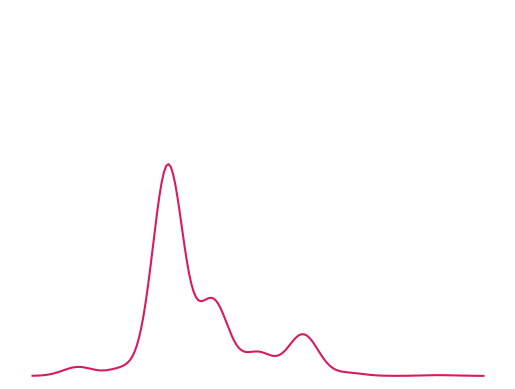

In [331]:
ax0 = sns.kdeplot(bclrM.bccs_[0].post_k, color='#D81B60')
plt.ylim(-0.01, ax2.get_ylim()[1])
plt.axis("off")
plt.savefig("ex_cp1.pdf")

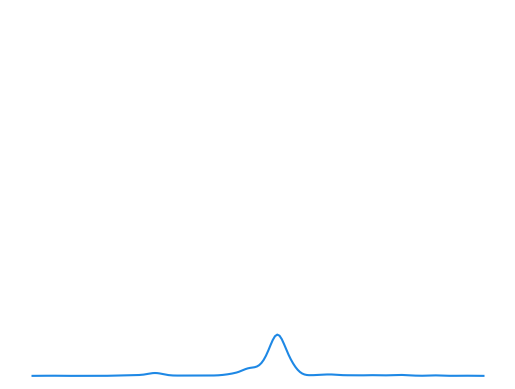

In [332]:
ax1 = sns.kdeplot(bclrM.bccs_[1].post_k, color="#1E88E5", bw_adjust=0.5)
plt.ylim(-0.01, ax2.get_ylim()[1])
plt.axis("off")
plt.savefig("ex_cp2.pdf")

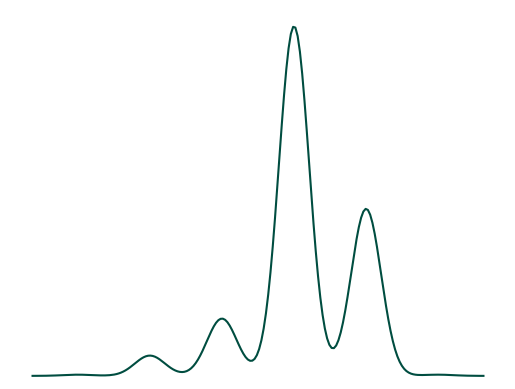

In [333]:
ax2 = sns.kdeplot(bclrM.bccs_[2].post_k, color="#004D40")
plt.ylim(-0.01, ax2.get_ylim()[1])
plt.axis("off")
plt.savefig("ex_cp3.pdf")

### Correctly identifies the changes in each coordinate!!!

In [8]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM.bccs_]

[array([0.024, 0.724, 0.422]),
 array([0., 0., 1.]),
 array([1., 0., 0.]),
 array([0.   , 0.002, 0.   ]),
 array([0.002, 0.   , 1.   ]),
 array([0.   , 0.002, 0.982]),
 array([0.202, 0.79 , 0.49 ])]

In [9]:
[bc.post_beta_mean for bc in bclrM.bccs_]

[array([-0.53317169,  0.16270272, -0.053303  ]),
 array([-0.77699724, -0.70982083,  1.42944108]),
 array([ 0.78134183, -1.95331026, -1.15620742]),
 array([-1.28253309, -0.85249274, -2.2035087 ]),
 array([-1.01644611, -1.64653441,  1.94956903]),
 array([-1.02341994, -0.73527313,  0.49216439]),
 array([-0.22171242,  0.24595397, -0.01369015])]

In [10]:
bkps2 = [0]+bkps
for i in range(len(bkps2)-1):
    print(np.mean(signal[bkps2[i]:bkps2[i+1], :], axis=0))

[4.85896743 7.09654116 1.66628311]
[0.75197459 2.18377263 8.08471679]
[ 4.0136651  -6.08451579  3.02110253]
[ -2.11727663 -10.87766866  -6.32345238]
[ -8.85192302 -18.9546945    2.23322792]
[-16.41716849 -22.84898953   5.15605168]


In [3]:
kern_cpd = rpt.KernelCPD(kernel='rbf')

In [180]:
kern_cpd = rpt.KernelCPD(kernel='rbf')
cp_kcp = kern_cpd.fit_predict(signal, pen=2)
print(cp_kcp[:-1])
print(randindex(cp_kcp, bkps))

[np.int32(173), np.int32(331)]
1.0


In [12]:
cp_cf = changeforest.changeforest(signal).split_points()
print(cp_cf)
print(randindex(cp_cf + [n], bkps))

[85, 175, 252, 333, 411]
0.9935390781563126


## What if we looked at changes of differing nature?

In [164]:
np.random.seed(881923)
h1 = np.array([[1, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
h2 = np.array([[4, 0.4, 0.1], [0.4, 1, 0], [0.1, 0, 1]])
h3 = np.array([[4, 0.4, -1.7], [0.4, 1, 0], [-1.7, 0, 1]])
L1 = np.linalg.cholesky(h1)
L2 = np.linalg.cholesky(h2)
L3 = np.linalg.cholesky(h3)

a = np.random.randn(100, 3) @ L1
b = np.random.randn(75, 3) @ L2
c = np.random.randn(30, 3) @ L2 + np.broadcast_to([0, 3, 0], (30, 3))
d = np.random.randn(45, 3) @ L3 + np.broadcast_to([0, 3, 0], (45, 3))

X = np.r_[a,b,c,d]
Xnew = ss.fit_transform(pf.fit_transform(np.r_[a,b,c,d]))
prior_cov9 = np.diag(np.repeat(1, 9))

In [165]:
bclrM_new = bclr.MultiBayesCC(Xnew, cps=6, prior_cov=prior_cov9, min_size=10)
cps=bclrM_new.predict()

bclr_multi.py:192: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 



In [166]:
def seg_to_lab(cps):
    K = len(cps)
    vals = [np.repeat(0, cps[0])] + [np.repeat(i, cps[i]-cps[i-1]) for i in range(1, K)]
    return np.concatenate(vals, axis=0)

def adj_rand(bkps, bkps_true):
    bkp_lab = seg_to_lab(bkps)
    bkp_labt = seg_to_lab(bkps_true)
    return adjusted_rand_score(bkp_lab, bkp_labt)

In [167]:
cps

,Location,Posterior Probability,Normalized Entropy
0,103.0,0.434,0.324319
1,175.0,0.916,0.075357
2,203.0,0.318,0.513936


In [168]:
changes = [100, 175, 205, 250]

In [169]:
cps_bclr = list(cps['Location'])+[250]
adj_rand(cps_bclr, changes)

0.948954660263192

In [170]:
randindex(cps_bclr, changes)

0.9787309236947791

### Now we can summarize the output of our algorithm...

In [171]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM_new.bccs_]

[array([0.486, 0.254, 0.436, 1.   , 0.708, 0.584, 0.77 , 0.518, 0.694]),
 array([0.378, 1.   , 0.736, 0.354, 0.308, 0.172, 1.   , 0.868, 0.242]),
 array([0.392, 0.518, 0.164, 0.728, 0.61 , 0.058, 0.136, 0.886, 0.   ])]

In [195]:
# This indciates that the x_1^2 increases the most in the first instance, 
# and x_2 for the second changepoint, thought x_2^2 is close...
[bc.post_beta_mean for bc in bclrM_new.bccs_]

[array([-0.00662118, -0.11575488, -0.03062079,  1.89756271,  0.14208189,
         0.04281333,  0.15281017,  0.01049932,  0.10359137]),
 array([-0.17499382,  2.32207062,  0.32999107, -0.20296456, -0.32290921,
        -0.44354844,  2.76939251,  0.63939743, -0.34411755]),
 array([-0.16360166,  0.02862344, -0.58390295,  0.17885505,  0.20588838,
        -0.61266104, -0.7197588 ,  0.89413212, -1.44473674])]

In [196]:
cf_res = changeforest.changeforest(Xnew).split_points()+[250]
print(cf_res)
print(randindex(cf_res, changes))

adj_rand(cf_res, changes)

[101, 175, 209, 250]
0.985285140562249


0.9645313839496815

In [197]:
e_divisive.e_divisive(Xnew)['estimates']

KeyboardInterrupt: 

In [175]:
kcp_slhr(Xnew)

[173, 250]

In [194]:
kern_cpd.fit_predict(X, n_bkps=2)

[173, 175, 250]

### Central England temperature series

In [22]:
import re
f = open("mean_temps_central_england.txt", "r")
lines = [re.sub(r"\n", "", re.sub(r"[ ]+", " ", a)).split(" ") for a in f.readlines()]

In [23]:
mtu = pd.DataFrame([l[1:] for l in lines[5:]], columns=lines[4][1:])
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)

In [24]:
cps = list(np.array([1700, 1738, 1988])-1658)

In [25]:
prior_cov1 = np.diag(np.repeat(10,1))
ncps = 7
bclrM_cet = bclr.MultiBayesCC(Xcet, cps=ncps, prior_cov=prior_cov1, min_size=20,
                              n_iter=1000, lam=0) #try also 9 changepoints to see what we find...
bclrM_cet.warm_up()

In [27]:
print(bclrM_cet.bkps)
bclrM_cet.prior_cov = np.diag(np.repeat(1,1))
bclrM_cet.fit()

[0, 47, 80, 101, 167, 238, 262, 330, 365]


In [29]:
bclrM_cet.transform()
df_dis = bclrM_cet.cps_df(0.7, offset=1658)
print(df_dis.sort_values(by=['Posterior Probability'], ascending=False))

   Location  Posterior Probability  Normalized Entropy
6    1988.0                  0.356            0.372806
1    1738.0                  0.290            0.634883
0    1701.0                  0.222            0.514829


In [98]:
from ecp import e_divisive

In [92]:
1658 + np.array([330, 43, 267, 81])

array([1988, 1701, 1925, 1739])

In [93]:
ecp_vals = e_divisive.e_divisive(Xcet)
np.array(ecp_vals['estimates'][1:-1]) + 1658

array([1701, 1925, 1988])

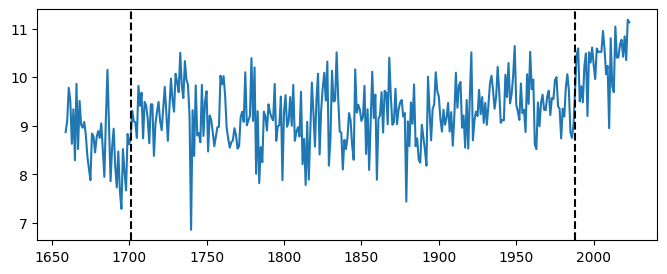

In [99]:
plt.figure(figsize=(8, 3))
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)
years = mtu[['Year']][:-1].to_numpy(dtype=np.double)
plt.plot(years[:], Xcet[:])
[plt.axvline(df_dis['Location'].iloc[i], color='black', linestyle='--') for i in range(len(df_dis))]

In [95]:
np.array(kern_cpd.fit_predict(Xcet, n_bkps = 3)[:-1])+1658

array([1699, 1910, 1987])

In [113]:
help(changeforest)

Help on package changeforest:

NAME
    changeforest

PACKAGE CONTENTS
    changeforest
    control
    plotting

CLASSES
    builtins.object
        builtins.BinarySegmentationResult
        builtins.OptimizerResult
        changeforest.control.Control
    
    class BinarySegmentationResult(object)
     |  Methods defined here:
     |  
     |  __repr__(self, /)
     |      Return repr(self).
     |  
     |  plot = _plot_binary_segmentation_result(binary_segmentation_result, max_depth=5)
     |  
     |  split_points(...)
     |  
     |  ----------------------------------------------------------------------
     |  Static methods defined here:
     |  
     |  __new__(*args, **kwargs) from builtins.type
     |      Create and return a new object.  See help(type) for accurate signature.
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  best_split
     |  
     |  is_significant
     |  
   

In [111]:
op = changeforest.changeforest(Xcet)
np.array(op.split_points())+1658

array([1982, 1988])